In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## ODE example

The following code is a version adapted from following sources:
- https://www.cs.uoi.gr/~lagaris/papers/TNN-LLF.pdf by A. Likas, E. Lagaris, and D. Fotiadis
- https://medium.com/mlearning-ai/deep-learning-solves-differential-equations-better-than-any-other-numerical-method-14126c7a2a7c

a first order ODE

$$ \frac{dy}{dt} = -\frac{1}{5}y + e^{-\frac{t}{5}}\cos t$$
The analytical solution is $$y(t) = e^{-\frac{t}{5}}\sin t$$

In [2]:


a = 0
b = 5
N = 200

x = torch.Tensor(np.linspace(a,b,N)[:,np.newaxis])



Train a Neural Network $ N(x, \theta) $
- Specify a trial solution that is a function of this neural network
- Train the neural network such that the trial solution fits the solution.
$$ y_{trial} = A + x N(x, \theta) $$ 
where $t \in [0,5]$ and $A = y(0) = 0$

## Defining the neural network
The network architecture used here:
- one input layer with one neuron that corresponds to each point $t_i$ in $[a,b]$ 
- one hidden layer with width M (neurons) 
- an output layer with 1 neuron that corresponds to the trial solution $y(t_i)$

In [3]:
M = 101

In [4]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))
def sigmoid_grad(x):
    return sigmoid(x)* ( 1-sigmoid(x))

In [5]:
def nn0(x, weights, bias):
    z = sigmoid(torch.matmul(x, weights[0])+bias[0]) # N * M array
    return torch.matmul(z, weights[1]) + bias[1] # back to output dimension, N*1
def dN_dx(weights,x, bias):
    
    s_grad = sigmoid_grad(torch.matmul(x, weights[0]) + bias[0]) # N * M (number of data points) by (width)
    mul = torch.mul(weights[0].T, weights[1]) # M * 1 (element wise)
    return torch.matmul(s_grad, mul) # return N*1

In [6]:
#initialize weights and bias
weights = [torch.randn( (1,M), requires_grad=True), torch.randn( (M,1), requires_grad=True)] #first element is for the input layer, second element is for the output layer 
bias = [torch.randn(M, requires_grad=True), torch.randn(1, requires_grad=True)]

In [7]:
A = 0 # boundary condition

f = lambda x, Psi: - Psi / 5.0 + torch.exp(-x/5.0) * torch.cos(x) # represent the RHS of the ODE, used as "target" in the loss function


In [8]:
num_epochs = 10000
lr = 0.01

In [9]:
for epoch in range(num_epochs):
    prediction  = A + x * nn0(x, weights, bias) # forward pass, runs the input data (x) through the network using new parameters, gives new solution Psi
    ddN = dN_dx(weights,x, bias)
    Psi_x = nn0(x, weights,bias) + x * ddN #derivative of Psi w.r.t. x (LHS of ODE)
    loss = torch.mean( (Psi_x - f(x,prediction)) ** 2) # error is MSE of (LHS-RHS), RHS is the f function

    loss.backward() # compute gradient
    for i in range(2): # "learning" : update parameters using the gradient
          weights[i].data -= lr * weights[i].grad.data
          bias[i].data -= lr * bias[i].grad.data
    for i in range(2):
          weights[i].grad.zero_()
          bias[i].grad.zero_()
      
    if epoch == 0:
         print('epoch' , ',' , 'loss')
    if epoch % 1000 == 0:
          print(epoch,',',"{:.2e}".format(loss.detach().numpy()))

epoch , loss
0 , 8.63e+00
1000 , 3.00e-03
2000 , 2.21e-03
3000 , 1.74e-03
4000 , 1.40e-03
5000 , 1.14e-03
6000 , 9.35e-04
7000 , 7.68e-04
8000 , 6.33e-04
9000 , 5.23e-04


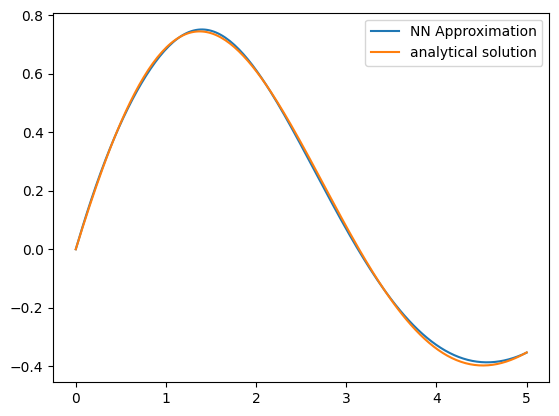

In [10]:
fig, ax = plt.subplots()
xplot = torch.unsqueeze(torch.linspace(a,b,N), dim=1)
y_ant = lambda x : torch.exp(-(x/5))*torch.sin(x) #analytical solution
Psi = A + x * nn0(xplot, weights,bias) # trial solution using the trained neural network
y_nn = Psi.detach().numpy()
ax.plot(xplot, y_nn, label='NN Approximation')
ax.plot(xplot, y_ant(xplot), label='analytical solution')

plt.legend()

### Alternative way to define neural network, using torch.nn module

In [11]:
train_data = x

In [12]:
import torch.nn as nn
import torch.nn.functional as F
class NN(nn.Module):
    def __init__(self,
                hidden_bias = True):
        super().__init__()
        self.hidden_bias = hidden_bias
        
        self.fc1 = nn.Linear(1,M, bias = self.hidden_bias)
        self.fc2 = nn.Linear(M,1, bias = self.hidden_bias)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return  x


#### Designing the Data Loader:
This is required to pass the data one by one to the optimizer

In [13]:
from torch.utils.data import Dataset, DataLoader
class Dataset_loader(Dataset):
    def __init__(self):
        self.train_data = train_data
        self.n_samples = self.train_data.shape[0]
    
    def __getitem__(self,index):
        return self.train_data[index]
    
    def __len__(self):
        return self.n_samples
      

In [14]:
dataset = Dataset_loader()
dataloader_GD = DataLoader(dataset = dataset, batch_size = N , shuffle = False) #GD: the whole dataset is passed each time
dataloader_SGD = DataLoader(dataset = dataset, batch_size = 50 , shuffle = True) #SGD: 50 points of the data is passed each time

We can see the size of the data used for each training loop under different dataloader 

In [15]:

for i, x in enumerate(dataloader_GD):
    print(i, x.shape)
print('\n')
for i, x in enumerate(dataloader_SGD):
    print(i, x.shape)

0 torch.Size([200, 1])


0 torch.Size([50, 1])
1 torch.Size([50, 1])
2 torch.Size([50, 1])
3 torch.Size([50, 1])


#### Training Loop: Gradient Descent

In [16]:
model_GD = NN()

learning_rate = 1e-2
optimizer = torch.optim.Adam(model_GD.parameters(), lr=learning_rate)
num_epochs = 1000

In [17]:
dNdx = torch.zeros(N)
for epoch in range(num_epochs):
    for i, x in enumerate(dataloader_GD):
        x.requires_grad = True
        prediction  = A + x * model_GD(x) # forward pass, runs the input data (x) through the network using new parameters, gives new solution Psi
        dNdx = (torch.autograd.grad(model_GD(x),x,grad_outputs=torch.ones(x.shape)))[0] #use autograd to calculate dN/dx
        Psi_x = model_GD(x) + x * dNdx #derivative of Psi w.r.t. x (LHS of ODE)
        loss = torch.mean( (Psi_x - f(x,prediction)) ** 2) # error is MSE of (LHS-RHS), RHS is the f function
        optimizer.zero_grad()
        loss.backward()
        dNdx = x.grad 
        optimizer.step()
               
    if epoch % 200 == 0:
        print(f"{epoch}, loss: {loss.data:.2e}")

0, loss: 1.05e+00
200, loss: 1.40e-02
400, loss: 2.20e-03
600, loss: 1.93e-04
800, loss: 8.72e-05


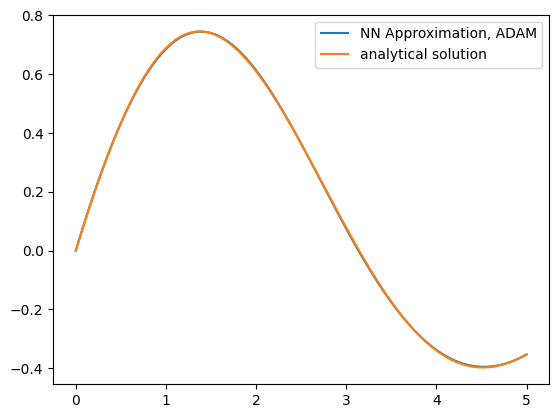

In [18]:
x_test = train_data

Psi_model = A + x_test * model_GD(x_test) # trial solution after learning
y_test = Psi_model.detach()

fig, ax = plt.subplots()

ax.plot(x_test, y_test, label='NN Approximation, ADAM')
ax.plot(x_test, y_ant(xplot), label='analytical solution')

plt.legend()